In [3]:
CONSUMER_KEY = "s90cdRHXfgsDZtsDMQ9TTN3oG"
CONSUMER_SECRET = "1Ci0WG7Q18zVaclyXuj9zrLv59PNWkKugStpnQ2qA46aA8B9jQ"
ACCESS_TOKEN = "193764648-pvrahvG6OVc8lSGBpsoXxg6HVZJSywH8kyRCGnES"
ACCESS_TOKEN_SECRET = "6X8hibxC0lEiv08klMIvJU4FQKdSf8Elvrg5fWapbUKP9"

# bearer_token = "AAAAAAAAAAAAAAAAAAAAAJnhMwEAAAAABmKWfOSq2A2ZxVT1jHK67EqiM1Q%3DNnw4T8qcGSq9Fw1zj35K6ZXFp0BeHNRi6uDg79n1N9OBzs1S3B"



In [35]:
import socket
import sys
import requests
import requests_oauthlib
import json
import tweepy
from tweepy import Cursor
from tweepy import Stream
from tweepy.streaming import StreamListener
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import time
import numpy as np

pd.set_option('display.width', 1000)
%matplotlib notebook

auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

## 1. Retrieve list of tweets with word 'python'

In [76]:
api = tweepy.API(auth, wait_on_rate_limit=True)

In [69]:
def tweet_to_df(search_results):
    dict_list = []
    for tweet in search_results:
        dict_list.append(tweet._json)

    with open('tweets.txt', 'w') as file:
            file.write(json.dumps(dict_list, indent=4))

    my_demo_list = []
    tweet_df = []
    with open('tweets.txt', encoding='utf-8') as json_file:  
        all_data = json.load(json_file)
        for d in all_data:
            tweet_id = d['id']

            # Retrieve full text of tweet, or retweet
            try:
                text = d['retweeted_status']['full_text']
            except KeyError:  # Not a Retweet
                text = d['full_text']

            retweet_count = d['retweet_count']
            created_at = d['created_at']
            my_demo_list.append({'tweet_id': str(tweet_id),
                                 'text': str(text),
                                 'retweet_count': int(retweet_count),
                                 'created_at': created_at,
                                })
            #print(my_demo_list)
            tweet_df = pd.DataFrame(my_demo_list, columns = 
                                      ['tweet_id', 
                                       'text', 
                                       'retweet_count', 
                                       'created_at'])
    return tweet_df

In [70]:
results = api.search(q="Python", lang="en", rpp=10, tweet_mode="extended")

tweet_df = tweet_to_df(results)
tweet_df = tweet_df.sort_values(by='retweet_count', ascending=False)
tweet_df.head()

,tweet_id,text,retweet_count,created_at
8,1364598957226229763,#InternetofThings Landscape in 2021🎯\n➡️https:...,33,Wed Feb 24 15:31:59 +0000 2021
6,1364598962024570880,A.I. Is Everywhere and Evolving\n\n#MachineLea...,24,Wed Feb 24 15:32:00 +0000 2021
0,1364599041452085248,These 7 tech investments are critical to build...,14,Wed Feb 24 15:32:19 +0000 2021
9,1364598947227009029,Coupons Free Discount - Typescript: The Comple...,13,Wed Feb 24 15:31:56 +0000 2021
14,1364598896471773192,This is what a human-centred approach to AI te...,9,Wed Feb 24 15:31:44 +0000 2021


In [71]:
tweet_df['text']

8     #InternetofThings Landscape in 2021🎯\n➡️https:...
6     A.I. Is Everywhere and Evolving\n\n#MachineLea...
0     These 7 tech investments are critical to build...
9     Coupons Free Discount - Typescript: The Comple...
14    This is what a human-centred approach to AI te...
3     Checkout we're providing #bulk #data of 3k plu...
1     Companies are using AI to hit business goals h...
10    Companies are using AI to hit business goals h...
11    Companies are using AI to hit business goals h...
13    Companies are using AI to hit business goals h...
12    Need help? Dm or email us at capitalexpertwrit...
2     (UDEMY \nLearn Python from Basics to Productio...
4     As I saw here once: #python is pseudocode thar...
5     Why #python why? If your parameter is def as a...
7     @python_engineer @PyTorch Hi Patrick, do you u...
Name: text, dtype: object

## 2. Plot frequency distribution of hashtags of incoming stream of tweets

In [16]:
def parse_hashtags(hashtag_list):
    # Function parses the list of hashtags, and return all list of hashtags in lower case
    ht = []
    
    for tag in hashtag_list:
        ht.append(tag['text'].lower())

    return ht

In [17]:
# Retrieve incoming tweet stream and write 
class MyStreamListener(tweepy.StreamListener):
    def __init__(self, api):
        self.api = api
        self.me = api.me()

    def on_status(self, tweet):
        if tweet.truncated == True:
            hashtags = parse_hashtags(tweet.extended_tweet['entities']['hashtags'])
        else:
            hashtags = parse_hashtags(tweet.entities['hashtags'])

#         print('items in list = ', len(hashtags))
        with open('hashtags.txt', 'a') as f:
            for item in hashtags:
                f.write("%s\n" % item)
            
    def on_error(self, status):
        print("Error detected")
        
        
api = tweepy.API(auth, wait_on_rate_limit=True,
    wait_on_rate_limit_notify=True)

tweets_listener = MyStreamListener(api)
stream = tweepy.Stream(api.auth, tweets_listener)
stream.filter(track=["Python", "Django", "Tweepy"], languages=["en"], is_async=True)

<IPython.core.display.Javascript object>


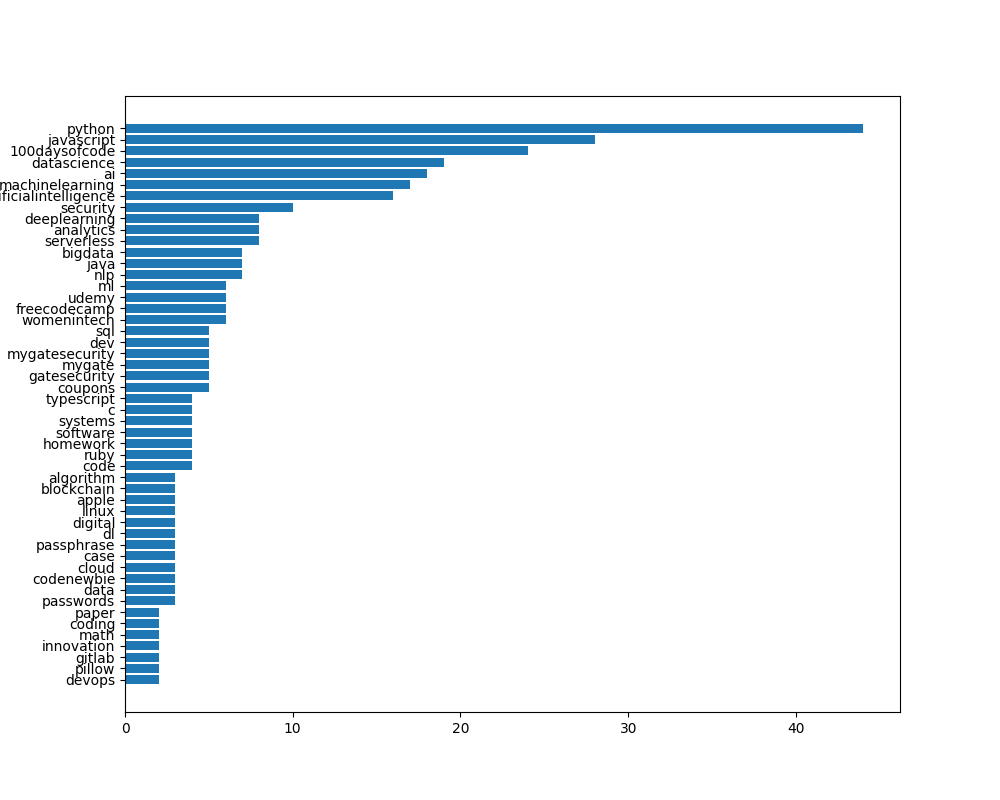

KeyboardInterrupt: 

In [20]:
def read_and_plot(ax):
    # Read text file of hashtags
    df = pd.read_csv('hashtags.txt', delimiter = "\n", names=['hashtag'])

    df_group = df[['hashtag']].groupby(['hashtag']).agg({'hashtag':['count']})
    df_group.columns = df_group.columns.to_flat_index()
    df_group.reset_index(inplace=True)
    df_group.columns = ['hashtag','count']

    # Sort by count and get top 50 tweets
    df_group.sort_values(by='count', ascending=False, inplace=True)
    df_group = df_group.head(50)
    
    y_labels = df_group['hashtag'].tolist()
    values = df_group['count'].tolist()
    
    # Clear previous axis before refresh
    ax.cla()
    plt.ion()
    plt.show()
    
    # Example data
    y_pos = np.arange(len(y_labels))
    
    ax.barh(y_pos, values, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(y_labels)
    ax.invert_yaxis()  # labels read top-to-bottom
    plt.draw()
    plt.pause(0.001)
    fig.canvas.draw()

figsize = (10, 8)
fig, ax = plt.subplots(figsize=figsize)

# Plot and refresh every 3s
while True:
    read_and_plot(ax)
    time.sleep(3)

## 3. Sentiment analysis of tweets related to Myanmar

In [87]:
search_terms = "#bitcoin-filter:retweets"

tweets = []
for tweet in tweepy.Cursor(api.search,
                           q=search_terms,
                           lang="en",
                           tweet_mode="extended",
                           since='2021-01-01').items(1000):
    tweets.append(tweet)
    
# tweets = Cursor(api.search,
#                    q=search_terms,
#                    lang="en",
#                    since='2021-01-01').items(1000)
tweet_df = tweet_to_df(tweets)

In [88]:
len(tweet_df)

273

In [89]:
from textblob import TextBlob

# Retain only text column, and perform sentiment analysis
tweet_list = tweet_df['text'].tolist()

sentiment_objects = [TextBlob(tweet) for tweet in tweet_list]

sentiment_values = [[tweet.sentiment.polarity, str(tweet)] for tweet in sentiment_objects]

# sentiment_objects[1].polarity, sentiment_objects[0]
sentiment_df = pd.DataFrame(sentiment_values, columns=["polarity", "tweet"])

sentiment_df.head()

,polarity,tweet
0,0.000000,Fight for our leader Aung San Suu Kyi and Free...
1,0.000000,@MayWongCNA @MFAThai @fmdonpram @Menlu_RI @ASE...
2,0.250000,@LeongWaiKitCNA Thank so much for telling true...
3,-0.195312,These Chin ethnic people are sending a message...
4,0.154167,@TostevinM @Reuters It is believed that Indone...


In [90]:
len(sentiment_df)

273

<IPython.core.display.Javascript object>


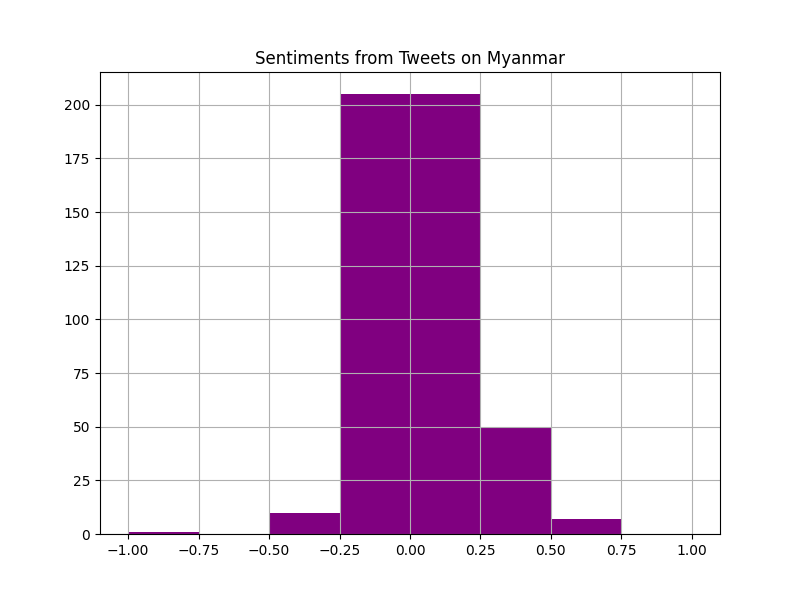

In [92]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram of the polarity values
sentiment_df.hist(bins=[-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="purple")

plt.title("Sentiments from Tweets on Myanmar")
plt.show()